In [1]:
import torch
from torch import nn
torch.cuda.is_available()
from torchgeo.samplers import RandomGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples
import os
from torchgeo.datasets import RasterDataset
import pylab as plt
import numpy as np

/mnt/work/python/dkottke/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BengaluruDataset(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """

    filename_glob = "*.tif"
    

class BengaluruDatasetLabels(RasterDataset):
    """
    Load xView3 polarization data that ends in *_dB.tif
    """
    is_image = False
    filename_glob = "*.tif"

In [3]:
# base path of the dataset
TRAIN_PATH = os.path.join("Data", "Train")
TEST_PATH = os.path.join("Data", "Test")

tr_labels = lambda x: x[:,0,:,:].long()

class TransBengaluruImages(nn.Module):
    """."""

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        inputs["image"] -= inputs["image"].min()
        inputs["image"] /= inputs["image"].max()
        
        return inputs
    
class TransBengaluruLabels(nn.Module):
    """."""

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        # Batch
        if inputs["mask"].ndim == 4:
            inputs["mask"] = (inputs["mask"][:,0,:,:]).long()
        # Sample
        else:
            inputs["mask"] = (inputs["mask"][0,:,:]).long()
        
        return inputs

ds = BengaluruDataset(os.path.join(TRAIN_PATH, "Images"), transforms=TransBengaluruImages())
la = BengaluruDatasetLabels(os.path.join(TRAIN_PATH, "Labels"), transforms=TransBengaluruLabels())

train_ds = ds & la

ds2 = BengaluruDataset(os.path.join(TEST_PATH, "Images"), transforms=TransBengaluruImages())
la2 = BengaluruDatasetLabels(os.path.join(TEST_PATH, "Labels"), transforms=TransBengaluruLabels())

test_ds = ds2 & la2

Converting BengaluruDatasetLabels resolution from 1.200444240953174 to 1.2004442409532352


In [4]:
DATASET_SIZE = 2048
BATCH_SIZE = 128
IMG_SIZE = 128


train_sampler = RandomGeoSampler(train_ds, size=IMG_SIZE, length=DATASET_SIZE)
test_sampler = RandomGeoSampler(test_ds, size=IMG_SIZE, length=DATASET_SIZE)

train_dl = DataLoader(train_ds, BATCH_SIZE, sampler=train_sampler, collate_fn=stack_samples)
test_dl  = DataLoader(test_ds, BATCH_SIZE, sampler=test_sampler, collate_fn=stack_samples)

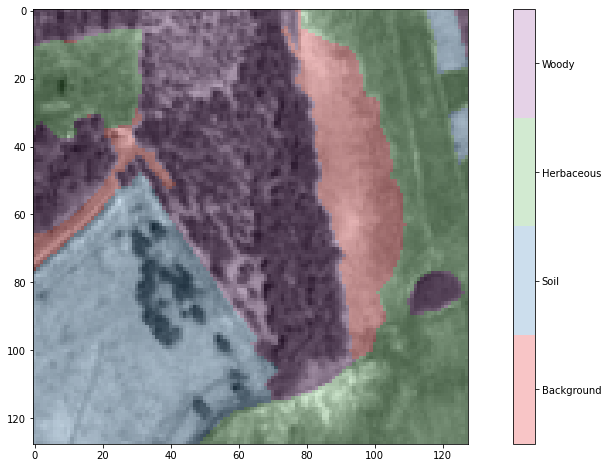

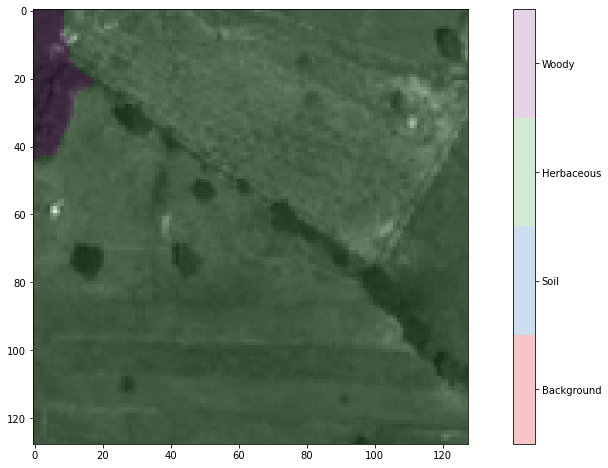

In [18]:
def visualize(image, mask):
    """PLot images in one row."""
    fig = plt.figure(figsize=(16, 8))
    #plt.imshow(image[0].transpose(0,2), vmin=0, vmax=1)
    image /= image.numpy().max()
    plt.imshow(image, cmap='gray')
    #plt.imshow(image[0])
    if mask.max()>0:
        plt.imshow(mask/9, alpha=0.25, vmin=0, vmax=1, cmap='Set1', interpolation='nearest')
        
    cb = plt.colorbar(cmap='Dark2', ticks=np.linspace(0.5/9, 3.5/9, 4), boundaries=np.linspace(0,4/9,5))
    cb.set_ticklabels(['Background', 'Soil', 'Herbaceous', 'Woody'])
    plt.show()

for dl in [train_dl, test_dl]:
    for sample in dl:
        idx = 0
        image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
        target = sample["mask"][idx, :, :]

        visualize(image, target)
        break

In [12]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)

        self.upconv4 = self.expand_block(256, 128, 3, 1)
        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [13]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for sampl in dataloader:
                x = sampl['image'].cuda()
                y = sampl['mask'].cuda()
                
                if x.isnan().any():
                    print('x nan')
                if y.isnan().any():
                    print('y nan')
                
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    
                    if outputs.isnan().any():
                        print('outputs nan')
                        break
                    loss = loss_fn(outputs, y)
                    

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc
                running_loss += loss 

                if step % 20 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / step
            epoch_acc = running_acc / step

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [14]:
unet = UNET(5, 4).cuda()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)

In [15]:
train_loss, valid_loss = train(unet, train_dl, test_dl, loss_fn, opt, acc_metric, epochs=100)

Epoch 0/99
----------
train Loss: 1.2483 Acc: 0.4522731304168701
valid Loss: 1.2625 Acc: 0.41094815731048584
Epoch 1/99
----------
train Loss: 0.9832 Acc: 0.6013884544372559
valid Loss: 1.4018 Acc: 0.4627722501754761
Epoch 2/99
----------
train Loss: 0.8596 Acc: 0.6581438183784485
valid Loss: 1.4168 Acc: 0.49909067153930664
Epoch 3/99
----------
train Loss: 0.7877 Acc: 0.6810989379882812
valid Loss: 1.0859 Acc: 0.6224837303161621
Epoch 4/99
----------
train Loss: 0.7651 Acc: 0.6858195066452026
valid Loss: 1.1567 Acc: 0.557612419128418
Epoch 5/99
----------
train Loss: 0.7632 Acc: 0.6978868842124939
valid Loss: 1.0512 Acc: 0.5425727367401123
Epoch 6/99
----------
train Loss: 0.7160 Acc: 0.7437885999679565
valid Loss: 0.9409 Acc: 0.5954886078834534
Epoch 7/99
----------
train Loss: 0.6909 Acc: 0.7487055063247681
valid Loss: 0.8688 Acc: 0.6200950145721436
Epoch 8/99
----------
train Loss: 0.6486 Acc: 0.7666410207748413
valid Loss: 0.8296 Acc: 0.6542561054229736
Epoch 9/99
----------
train

In [16]:
torch.save(unet, 'unet_128px-4ly.pt')

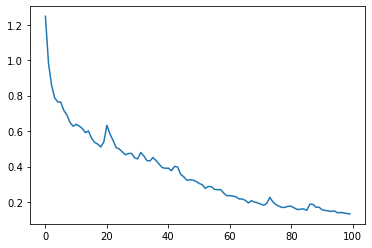

In [24]:
plt.plot([t.detach().cpu().numpy() for t in train_loss])

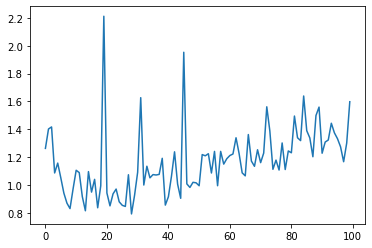

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/mnt/work/python/dkottke/pytorch/lib/python3.9/site-packages/IPython/core/history.py", line 804, in writeout_cache
  File "/mnt/work/python/dkottke/pytorch/lib/python3.9/site-packages/IPython/core/history.py", line 787, in _writeout_input_cache
sqlite3.OperationalError: disk I/O error


In [25]:
plt.plot([t.detach().cpu().numpy() for t in valid_loss])

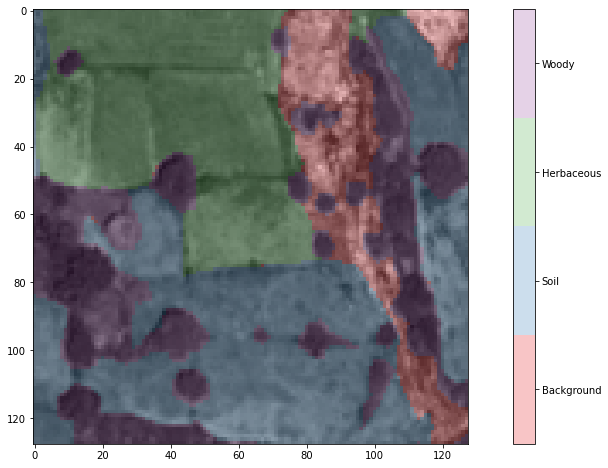

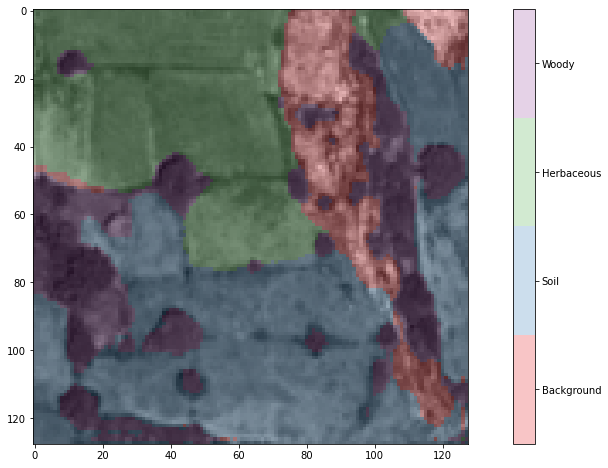

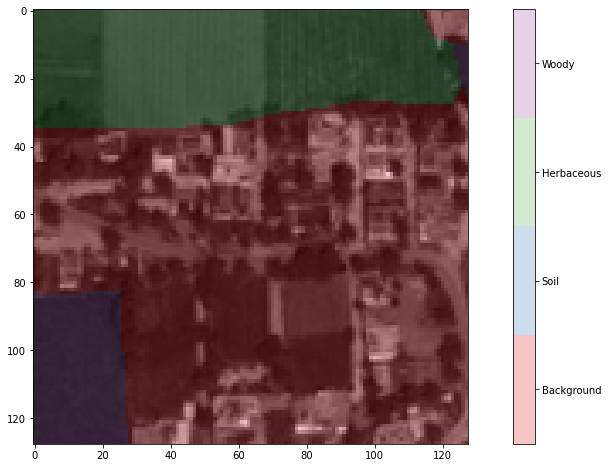

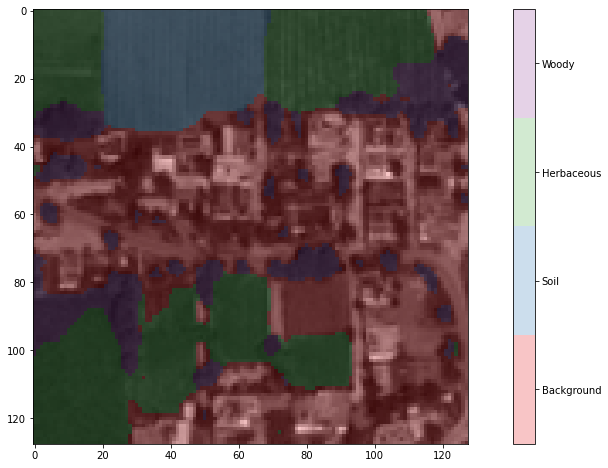

In [23]:
for dl in [train_dl, test_dl]:
    for sample in dl:
        idx = 0
        image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
        target = sample["mask"][idx, :, :]
        pred = unet(sample["image"].cuda()).cpu()[0]

        visualize(image, target)
        visualize(image, torch.argmax(pred, 0))
        break

In [ ]:
pred

In [ ]:
for sample in test_dl:
    print(unet(sample['image'].cuda()).isnan().any())


In [ ]:
unet = UNET(5, 4)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)

x = sample['image'].cuda()
y = sample['mask'].cuda()

unet.train(True)
loss = loss_fn(unet(x), y)
print(loss)
#opt.zero_grad()
loss.backward()
opt.step()
loss_fn(unet(unet(x), y))

In [ ]:
target.shape

In [ ]:
torch.argmax(pred, 0).shape